# BCI transfer learning algorithm implementation

This notebook contains tests of multi-task learning algorithm described in <a href="https://ieeexplore.ieee.org/document/7379089">Transfer Learning in Brain-Computer Interfaces</a> referenced here as **Algorithm 1**. My implementation is based on source code that can be found <a  href="https://github.com/vinay-jayaram/MTlearning/blob/master/MT_linear.m">here</a>.  
An upgrade of Algorithm 1 described in <a href="https://link.springer.com/article/10.1007/s11517-020-02176-y">EEG classification across sessions and across subjects through transfer learning in motor imagery-based brain-machine interface system</a> referenced as **Algorithm 2**, is also tested here.  
The dataset used for testing is BCI Competition 2008 B.


# Imports and environment


In [36]:
import sys
import os
import warnings
import mne

warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
mne.set_config("MNE_DATA", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_BNCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_EEGBCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_SHIN_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MOABB_RESULTS", os.path.join(os.getcwd(), "results"))
os.makedirs(os.environ["MNE_DATA"], exist_ok=True)
os.makedirs(os.environ["MOABB_RESULTS"], exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from importlib import reload
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import scripts.multi_task.linear as linear
import scripts.multi_task.linear_data_selection as linear_ds
import scripts.features_extract.welch as welch
from eeg_logger import logger

import moabb
from moabb.datasets import BNCI2014_004
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")

# Instantiate dataset


In [37]:
dataset = BNCI2014_004()
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
channels = ["C3", "Cz", "C4"]
paradigm = LeftRightImagery(channels=channels, fmin=2, fmax=32)

# Prepare train and test data

The data is organised as follows:

- **X_all** - all data from epochs regarding left/right hand movement
- **y_all** - all labels from epochs regarding left/right hand movement
- **X_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (4, ) representing 4 sessions of each patient.
- **y_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (4, ) representing sessions' labels for each patient
- **X_test** - array of shape (n_subjects, ) where each element represents data from the last session of each subject
- **y_test** - array of shape (n_subjects, ) where each element represents labels from the last session of each subject


In [47]:
reload(welch)

X_all, y_all, metadata = paradigm.get_data(dataset, subjects=dataset.subject_list, return_epochs=False)
subjects = metadata["subject"].unique()
sessions = metadata["session"].unique()

X_train = np.empty(len(subjects), dtype=object)
X_test = np.empty(len(subjects), dtype=object)
y_train = np.empty(len(subjects), dtype=object)
y_test = np.empty(len(subjects), dtype=object)
label_map = {"left_hand": 1, "right_hand": -1}
welch_bands = [
    (8, 10),
    (10, 12),
    (12, 14),
    (14, 16),
    (16, 22),
    (22, 24),
    (24, 26),
    (26, 28),
    (28, 30),
    (28, 32),
]


for idx, subject in enumerate(subjects):

    sess_1_mask = (metadata["subject"] == subject) & (metadata["session"] == "0train")
    sess_2_mask = (metadata["subject"] == subject) & (metadata["session"] == "1train")
    sess_3_mask = (metadata["subject"] == subject) & (metadata["session"] == "2train")
    sess_4_mask = (metadata["subject"] == subject) & (metadata["session"] == "3test")
    sess_5_mask = (metadata["subject"] == subject) & (metadata["session"] == "4test")

    X_sess_1 = X_all[sess_1_mask]
    y_sess_1 = y_all[sess_1_mask]
    X_sess_2 = X_all[sess_2_mask]
    y_sess_2 = y_all[sess_2_mask]
    X_sess_3 = X_all[sess_3_mask]
    y_sess_3 = y_all[sess_3_mask]
    X_sess_4 = X_all[sess_4_mask]
    y_sess_4 = y_all[sess_4_mask]
    X_sess_5 = X_all[sess_5_mask]
    y_sess_5 = y_all[sess_5_mask]

    X_sess_1_feat = welch.extract_welch_features(welch_bands, X_sess_1, apply_log=False)
    y_sess_1 = np.array([label_map[label] for label in y_sess_1])
    X_sess_2_feat = welch.extract_welch_features(welch_bands, X_sess_2, apply_log=False)
    y_sess_2 = np.array([label_map[label] for label in y_sess_2])
    X_sess_3_feat = welch.extract_welch_features(welch_bands, X_sess_3, apply_log=False)
    y_sess_3 = np.array([label_map[label] for label in y_sess_3])
    X_sess_4_feat = welch.extract_welch_features(welch_bands, X_sess_4, apply_log=False)
    y_sess_4 = np.array([label_map[label] for label in y_sess_4])
    X_sess_5_feat = welch.extract_welch_features(welch_bands, X_sess_5, apply_log=False)
    y_sess_5 = np.array([label_map[label] for label in y_sess_5])

    X_subject_train = np.empty(4, dtype=object)
    X_subject_train[0] = X_sess_1_feat.T
    X_subject_train[1] = X_sess_2_feat.T
    X_subject_train[2] = X_sess_3_feat.T
    X_subject_train[3] = X_sess_4_feat.T
    y_subject_train = np.empty(4, dtype=object)
    y_subject_train[0] = y_sess_1.reshape(-1, 1)
    y_subject_train[1] = y_sess_2.reshape(-1, 1)
    y_subject_train[2] = y_sess_3.reshape(-1, 1)
    y_subject_train[3] = y_sess_4.reshape(-1, 1)

    X_train[idx] = X_subject_train
    y_train[idx] = y_subject_train
    X_test[idx] = X_sess_5_feat.T
    y_test[idx] = y_sess_5.reshape(-1, 1)

2025-10-03 12:01:58,514 - INFO - Welch features extracted, vector's shape: (120, 30)
2025-10-03 12:01:58,585 - INFO - Welch features extracted, vector's shape: (120, 30)
2025-10-03 12:01:58,664 - INFO - Welch features extracted, vector's shape: (160, 30)
2025-10-03 12:01:58,760 - INFO - Welch features extracted, vector's shape: (160, 30)
2025-10-03 12:01:58,847 - INFO - Welch features extracted, vector's shape: (160, 30)
2025-10-03 12:01:58,972 - INFO - Welch features extracted, vector's shape: (120, 30)
2025-10-03 12:01:59,041 - INFO - Welch features extracted, vector's shape: (120, 30)
2025-10-03 12:01:59,133 - INFO - Welch features extracted, vector's shape: (160, 30)
2025-10-03 12:01:59,205 - INFO - Welch features extracted, vector's shape: (120, 30)
2025-10-03 12:01:59,294 - INFO - Welch features extracted, vector's shape: (160, 30)
2025-10-03 12:01:59,374 - INFO - Welch features extracted, vector's shape: (120, 30)
2025-10-03 12:01:59,432 - INFO - Welch features extracted, vector

# Testing classifier across sessions (Algorithm 1)

First, classifier learns basic prior info based on four sessions of current patient.  
This creates a shared model with prior info.  
Then shared model is tested on the fifth session of current patient.


In [53]:
accuracies = []
algorithm_1_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):
    clf = linear.MultiTaskLinearClassifier(regularization=0.1, zero_mean=False, cov_flag="l1")
    clf.fit_sessions(X_train[idx], y_train[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])
    accuracies.append(acc * 100)
    algorithm_1_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_1_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_1_results["accuracies"] = accuracies

2025-10-03 12:11:33,982 - INFO - Accuracy for subject 0: 0.64
2025-10-03 12:11:34,357 - INFO - Accuracy for subject 1: 0.59
2025-10-03 12:11:34,793 - INFO - Accuracy for subject 2: 0.54
2025-10-03 12:11:35,122 - INFO - Accuracy for subject 3: 0.93
2025-10-03 12:11:35,380 - INFO - Accuracy for subject 4: 0.88
2025-10-03 12:11:35,665 - INFO - Accuracy for subject 5: 0.90
2025-10-03 12:11:35,877 - INFO - Accuracy for subject 6: 0.81
2025-10-03 12:11:36,097 - INFO - Accuracy for subject 7: 0.96
2025-10-03 12:11:36,329 - INFO - Accuracy for subject 8: 0.85
2025-10-03 12:11:36,329 - INFO - Mean accuracy across subjects: 78.89


# Plot results (Algorithm 1)


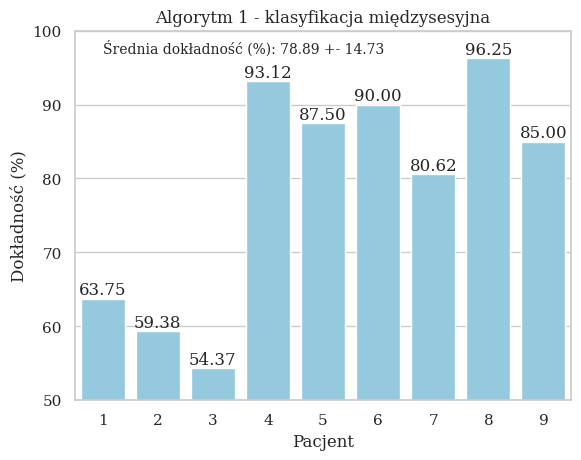

In [54]:
axes = sns.barplot(data=algorithm_1_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(50, 100)
axes.bar_label(axes.containers[0], fmt="%.2f", fontsize=12)
axes.set_title(f"Algorytm 1 - klasyfikacja międzysesyjna")
plt.text(
    x=0,
    y=97,
    s=f"Średnia dokładność (%): {np.mean(algorithm_1_results['accuracies']):.2f} +- {np.std(algorithm_1_results['accuracies']):.2f}",
    fontsize=10,
)
axes.set_ylabel("Dokładność (%)")
axes.set_xlabel("Pacjent")
plt.show()

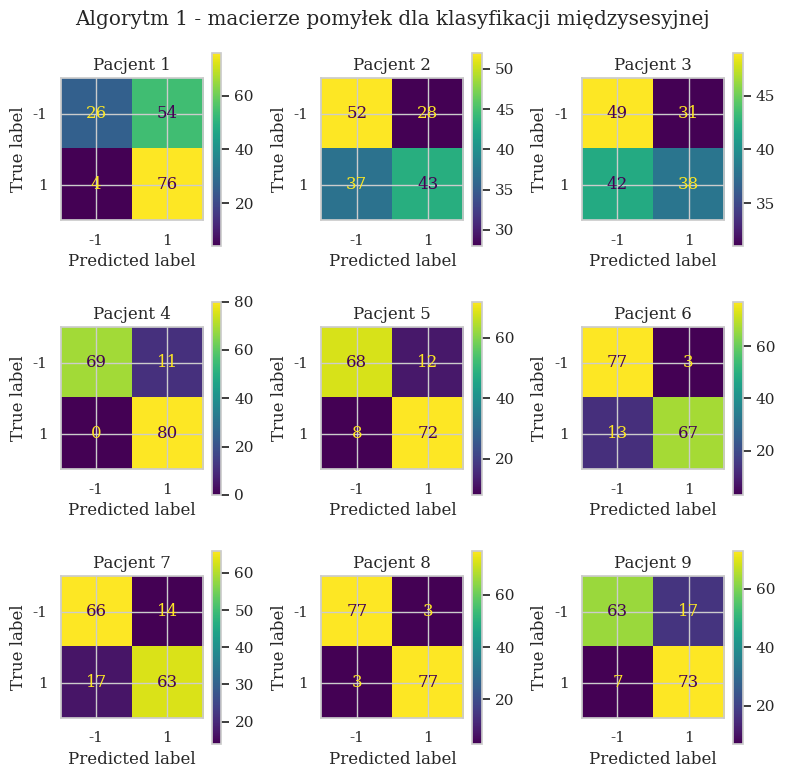

In [58]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i, subj_idx in enumerate(subjects):
    test = algorithm_1_results[f"subj_{subj_idx}_test_labels"]
    pred = algorithm_1_results[f"subj_{subj_idx}_pred_labels"]
    cm = confusion_matrix(test, pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
    disp.plot(ax=axes[i], values_format="d")
    axes[i].set_title(f"Pacjent {subj_idx}")
fig.suptitle("Algorytm 1 - macierze pomyłek dla klasyfikacji międzysesyjnej")
plt.tight_layout()

# Testing classifier across sessions (Algorithm 2)

First, shared model is acquired the same way as for previous testing pipeline.  
The test data is used to calculate weight vector for this task and select prior vectors that match the new vector the most.


In [56]:
def split_test_session(X: np.ndarray, y: np.ndarray):
    from sklearn.model_selection import train_test_split

    X_adapt, X_eval, y_adapt, y_eval = train_test_split(X.T, y, train_size=0.5, shuffle=True, random_state=42)
    return X_adapt.T, X_eval.T, y_adapt, y_eval


accuracies = []
algorithm_2_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):

    clf = linear_ds.MultiTaskLinearWithSelectionClassifier(
        regularization=0.1, zero_mean=False, cov_flag="l1", verbose=False
    )
    clf.fit_sessions_with_selection(X_train[idx], y_train[idx], X_test[idx], y_test[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])

    accuracies.append(acc * 100)
    algorithm_2_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_2_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_2_results["accuracies"] = accuracies

2025-10-03 12:11:47,945 - INFO - Accuracy for subject 0: 0.64
2025-10-03 12:11:48,216 - INFO - Accuracy for subject 1: 0.59
2025-10-03 12:11:48,507 - INFO - Accuracy for subject 2: 0.54
2025-10-03 12:11:48,843 - INFO - Accuracy for subject 3: 0.93
2025-10-03 12:11:49,419 - INFO - Accuracy for subject 4: 0.89
2025-10-03 12:11:49,908 - INFO - Accuracy for subject 5: 0.91
2025-10-03 12:11:50,151 - INFO - Accuracy for subject 6: 0.81
2025-10-03 12:11:50,362 - INFO - Accuracy for subject 7: 0.96
2025-10-03 12:11:50,756 - INFO - Accuracy for subject 8: 0.86
2025-10-03 12:11:50,756 - INFO - Mean accuracy across subjects: 79.24


# Plot results (Algorithm 2)


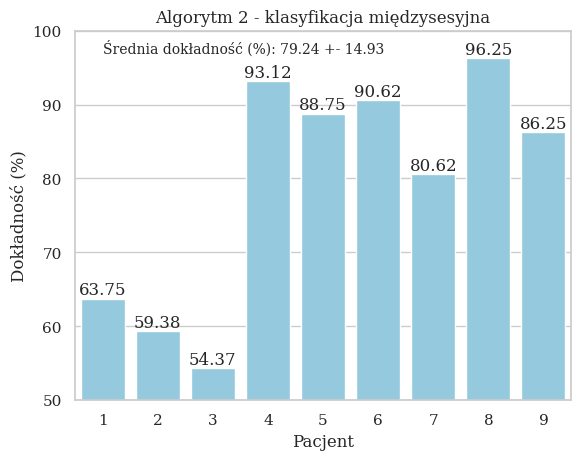

In [57]:
axes = sns.barplot(data=algorithm_2_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(50, 100)
axes.bar_label(axes.containers[0], fmt="%.2f", fontsize=12)
axes.set_title(f"Algorytm 2 - klasyfikacja międzysesyjna")
plt.text(
    x=0,
    y=97,
    s=f"Średnia dokładność (%): {np.mean(algorithm_2_results['accuracies']):.2f} +- {np.std(algorithm_2_results['accuracies']):.2f}",
    fontsize=10,
)
axes.set_ylabel("Dokładność (%)")
axes.set_xlabel("Pacjent")
plt.show()

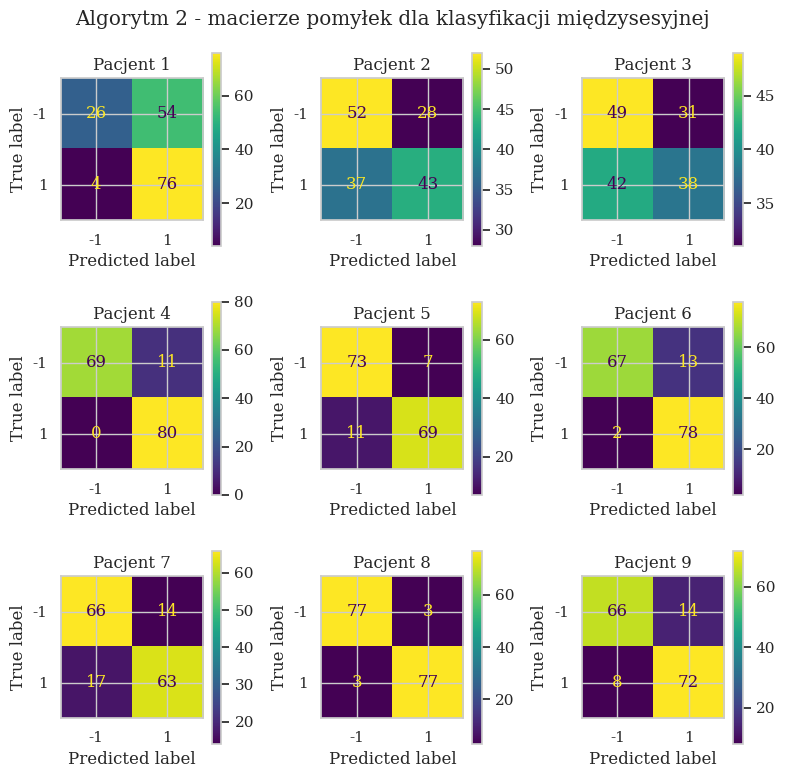

In [59]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i, subj_idx in enumerate(subjects):
    test = algorithm_2_results[f"subj_{subj_idx}_test_labels"]
    pred = algorithm_2_results[f"subj_{subj_idx}_pred_labels"]
    cm = confusion_matrix(test, pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
    disp.plot(ax=axes[i], values_format="d")
    axes[i].set_title(f"Pacjent {subj_idx}")
fig.suptitle("Algorytm 2 - macierze pomyłek dla klasyfikacji międzysesyjnej")
plt.tight_layout()

# Testing classifier across subjects (Algorithm 1)

Here, classifier is used on data from sessions between subjects. The pipeline is build like this:

- use all sessions from current subject (Si) and I sessions from next subject (Sm), where I = 1...4 as training data to build shared model
- test the model on I + 1 session data of subject Sm


### Prepare data first - concatenate data from previous train and test arrays for easier selection.

- **X_cross_subj** - shape (n_subjects, ) that contains 5 numpy arrays for each session
- **y_cross_subj** - shape (n_subjects, ) that contains 5 numpy arrays for labels for each session


In [51]:
X_cross_subj = np.empty(len(subjects), dtype=object)
y_cross_subj = np.empty(len(subjects), dtype=object)

for idx, subj in enumerate(subjects):

    X_si_train = X_train[idx]
    y_si_train = y_train[idx]
    X_si_test = X_test[idx]
    y_si_test = y_test[idx]

    X_si_test_wrapped = np.empty(1, dtype=object)
    X_si_test_wrapped[0] = X_si_test
    y_si_test_wrapped = np.empty(1, dtype=object)
    y_si_test_wrapped[0] = y_si_test
    X_si_all = np.concatenate((X_si_train, X_si_test_wrapped), axis=0)
    y_si_all = np.concatenate((y_si_train, y_si_test_wrapped), axis=0)

    X_cross_subj[idx] = X_si_all
    y_cross_subj[idx] = y_si_all

### Use cross-subject data for classification (Algorithm 1)


In [52]:
cross_subject_results = []
accuracies = []
for subj_idx, _ in enumerate(subjects):
    next_subj_idx = subj_idx + 1
    if next_subj_idx == len(subjects):
        break

    for sess_idx in range(1, len(sessions) + 1):
        if sess_idx == len(sessions):
            break

        X_cs_train = np.concatenate((X_cross_subj[subj_idx], X_cross_subj[next_subj_idx][:sess_idx]))
        y_cs_train = np.concatenate((y_cross_subj[subj_idx], y_cross_subj[next_subj_idx][:sess_idx]))
        X_cs_test = X_cross_subj[next_subj_idx][sess_idx]
        y_cs_test = y_cross_subj[next_subj_idx][sess_idx]

        clf = linear.MultiTaskLinearClassifier(regularization=0.1, cov_flag="l1", zero_mean=False, verbose=False)
        clf.fit_sessions(X_cs_train, y_cs_train)

        acc, y_pred = clf.score(X_cs_test, y_cs_test)

        cross_subject_results.append(
            {
                "train_desc": f"S{subj_idx + 1}",
                "eval_desc": f"S{next_subj_idx + 1}:{sess_idx}",
                "accuracy": acc * 100,
            }
        )
        accuracies.append(acc * 100)

        logger.info(
            f"Training on S{subj_idx} + S{next_subj_idx}:{sess_idx}, test on S{next_subj_idx}:{sess_idx + 1} acc = {acc:.2f}"
        )

logger.info(f"Mean accuracy: {np.mean(accuracies):.2f}")

2025-09-29 00:28:28,025 - INFO - Training on S0 + S1:1, test on S1:2 acc = 0.57
2025-09-29 00:28:28,585 - INFO - Training on S0 + S1:2, test on S1:3 acc = 0.59
2025-09-29 00:28:29,215 - INFO - Training on S0 + S1:3, test on S1:4 acc = 0.63
2025-09-29 00:28:29,750 - INFO - Training on S0 + S1:4, test on S1:5 acc = 0.59
2025-09-29 00:28:30,094 - INFO - Training on S1 + S2:1, test on S2:2 acc = 0.56
2025-09-29 00:28:30,479 - INFO - Training on S1 + S2:2, test on S2:3 acc = 0.53
2025-09-29 00:28:30,766 - INFO - Training on S1 + S2:3, test on S2:4 acc = 0.54
2025-09-29 00:28:31,086 - INFO - Training on S1 + S2:4, test on S2:5 acc = 0.56
2025-09-29 00:28:31,398 - INFO - Training on S2 + S3:1, test on S3:2 acc = 0.88
2025-09-29 00:28:31,682 - INFO - Training on S2 + S3:2, test on S3:3 acc = 0.98
2025-09-29 00:28:31,965 - INFO - Training on S2 + S3:3, test on S3:4 acc = 0.98
2025-09-29 00:28:32,300 - INFO - Training on S2 + S3:4, test on S3:5 acc = 0.94
2025-09-29 00:28:32,557 - INFO - Trainin

# Plot cross-subject accuracy (Algorithm 1)


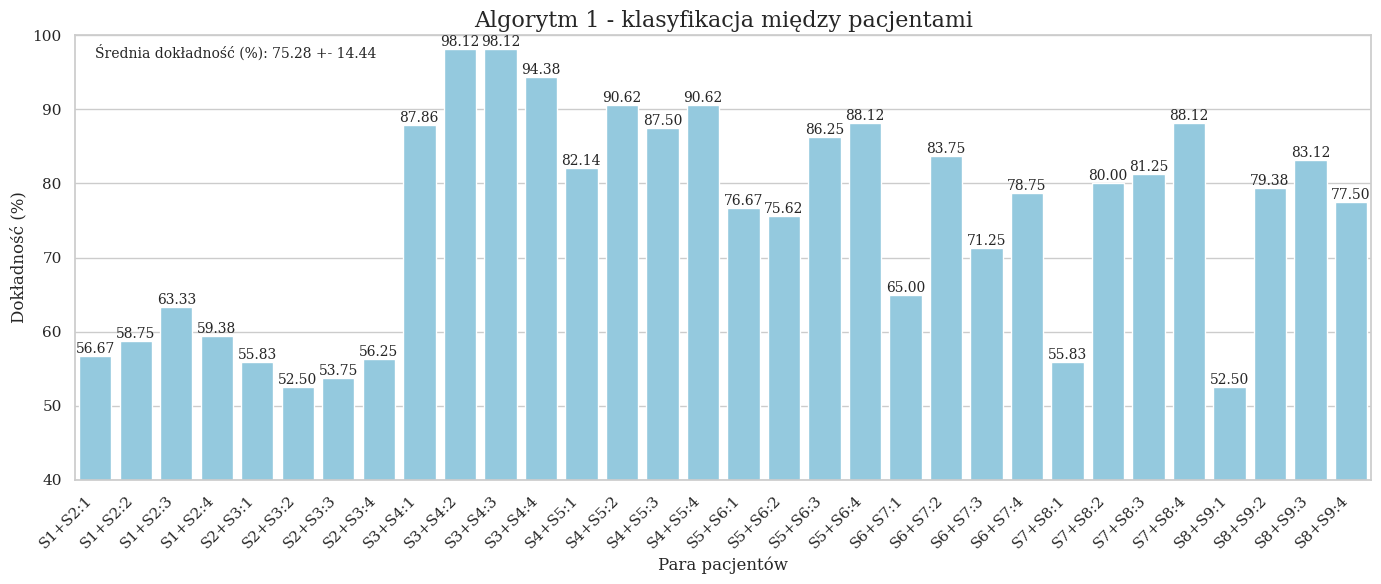

In [54]:
df = pd.DataFrame(cross_subject_results)
df["transfer_pair"] = df["train_desc"] + "+" + df["eval_desc"]

plt.figure(figsize=(14, 6))
axes = sns.barplot(data=df, x="transfer_pair", y="accuracy", color="skyblue")
axes.set_ylim(40, 100)
axes.set_title(f"Algorytm 1 - klasyfikacja między pacjentami", fontsize=16)
plt.text(
    x=0,
    y=97,
    s=f"Średnia dokładność (%): {np.mean(accuracies):.2f} +- {np.std(accuracies):.2f}",
    fontsize=10,
)
axes.bar_label(axes.containers[0], fmt="%.2f", fontsize=10)
axes.set_ylabel("Dokładność (%)")
axes.set_xlabel("Para pacjentów")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Testing classifier across subjects (Algorithm 2)

The pipeline is the same as in Algorithm 1, except the test session is split before fine-tuning the shared model.


In [55]:
cross_subject_results = []
accuracies = []
reload(linear_ds)
for subj_idx, _ in enumerate(subjects):
    next_subj_idx = subj_idx + 1
    if next_subj_idx == len(subjects):
        break

    for sess_idx in range(1, len(sessions) + 1):
        if sess_idx == len(sessions):
            break

        X_cs_train = np.concatenate((X_cross_subj[subj_idx], X_cross_subj[next_subj_idx][:sess_idx]))
        y_cs_train = np.concatenate((y_cross_subj[subj_idx], y_cross_subj[next_subj_idx][:sess_idx]))
        X_cs_test = X_cross_subj[next_subj_idx][sess_idx]
        y_cs_test = y_cross_subj[next_subj_idx][sess_idx]

        clf = linear_ds.MultiTaskLinearWithSelectionClassifier(
            regularization=0.1, cov_flag="l1", zero_mean=False, verbose=False
        )
        clf.fit_sessions_with_selection(X_cs_train, y_cs_train, X_cs_test, y_cs_test)
        acc, y_pred = clf.score(X_cs_test, y_cs_test)

        cross_subject_results.append(
            {
                "train_desc": f"S{subj_idx + 1}",
                "eval_desc": f"S{next_subj_idx + 1}:{sess_idx}",
                "accuracy": acc * 100,
            }
        )
        accuracies.append(acc * 100)

        logger.info(
            f"Training on S{subj_idx} + S{next_subj_idx}:{sess_idx}, test on S{next_subj_idx}:{sess_idx + 1} acc = {acc:.2f}"
        )

logger.info(f"Mean accuracy: {np.mean(accuracies):.2f}")

2025-09-29 00:29:29,493 - INFO - Training on S0 + S1:1, test on S1:2 acc = 0.57
2025-09-29 00:29:29,815 - INFO - Training on S0 + S1:2, test on S1:3 acc = 0.59
2025-09-29 00:29:30,271 - INFO - Training on S0 + S1:3, test on S1:4 acc = 0.63
2025-09-29 00:29:31,054 - INFO - Training on S0 + S1:4, test on S1:5 acc = 0.59
2025-09-29 00:29:31,452 - INFO - Training on S1 + S2:1, test on S2:2 acc = 0.56
2025-09-29 00:29:31,931 - INFO - Training on S1 + S2:2, test on S2:3 acc = 0.49
2025-09-29 00:29:32,434 - INFO - Training on S1 + S2:3, test on S2:4 acc = 0.52
2025-09-29 00:29:32,974 - INFO - Training on S1 + S2:4, test on S2:5 acc = 0.55
2025-09-29 00:29:33,246 - INFO - Training on S2 + S3:1, test on S3:2 acc = 0.88
2025-09-29 00:29:33,548 - INFO - Training on S2 + S3:2, test on S3:3 acc = 0.98
2025-09-29 00:29:33,938 - INFO - Training on S2 + S3:3, test on S3:4 acc = 0.98
2025-09-29 00:29:34,481 - INFO - Training on S2 + S3:4, test on S3:5 acc = 0.91
2025-09-29 00:29:34,996 - INFO - Trainin

# Plot cross-subject accuracy (Algorithm 2)


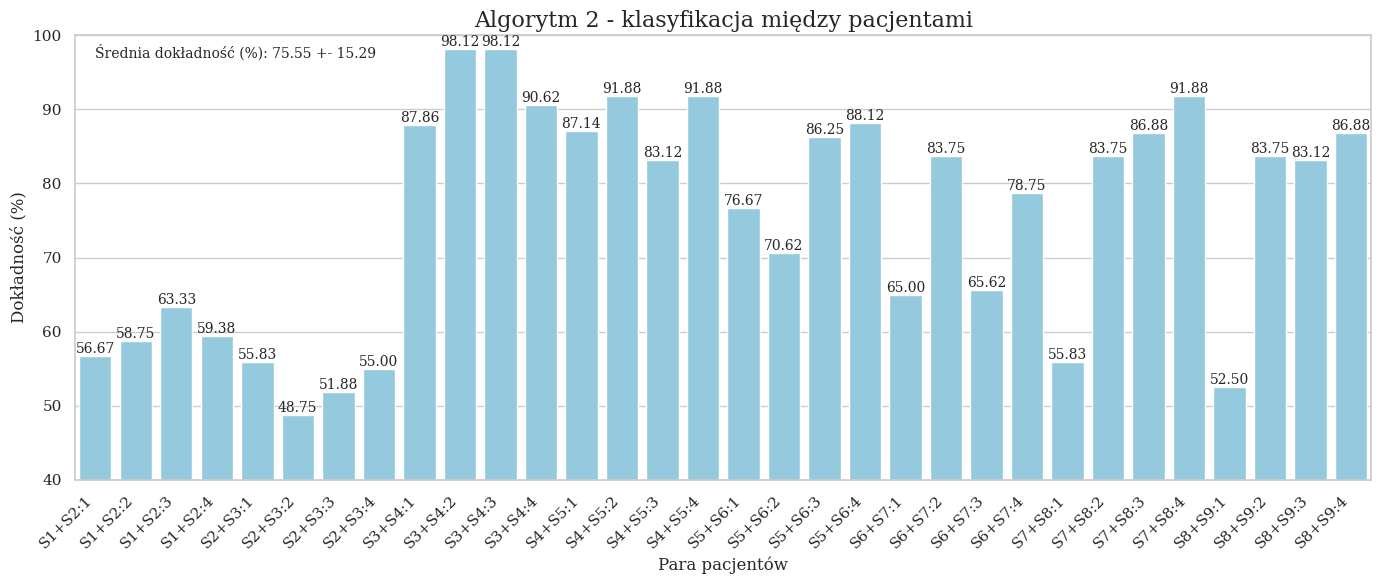

In [56]:
df = pd.DataFrame(cross_subject_results)
df["transfer_pair"] = df["train_desc"] + "+" + df["eval_desc"]

plt.figure(figsize=(14, 6))
axes = sns.barplot(data=df, x="transfer_pair", y="accuracy", color="skyblue")
axes.set_ylim(40, 100)
axes.set_title(f"Algorytm 2 - klasyfikacja między pacjentami", fontsize=16)
plt.text(
    x=0,
    y=97,
    s=f"Średnia dokładność (%): {np.mean(accuracies):.2f} +- {np.std(accuracies):.2f}",
    fontsize=10,
)
axes.bar_label(axes.containers[0], fmt="%.2f", fontsize=10)
axes.set_ylabel("Dokładność (%)")
axes.set_xlabel("Para pacjentów")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()